In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

%matplotlib inline

In [2]:
filename = 'query_result_2019-12-24T07_29_06.659397Z.csv'

In [3]:
data = pd.read_csv(filename,
                   sep         = ';|,',
                   engine      = 'python', 
                   index_col   = ['Time Start Local Tz'],
                   parse_dates = ['Time End', 'Time Start', 
                                  'Time End Local Tz',
                                  'Time Start Local Tz'])

In [4]:
data.dtypes

Time End             datetime64[ns, pytz.FixedOffset(180)]
Time End Local Tz    datetime64[ns, pytz.FixedOffset(180)]
Time Offset                                          int64
Time Start           datetime64[ns, pytz.FixedOffset(180)]
User ID                                              int64
Value                                              float64
dtype: object

Рассмотрим исходный набор данных. Колонки 'Time End', 'Time Start', 'Time Offset' в данном случае несут избыточную информацию. Местное время получим из соответствующих колонок, информация о часовом поясе также находится в колонках времени

In [5]:
data.head(5)

,Time End,Time End Local Tz,Time Offset,Time Start,User ID,Value
Time Start Local Tz,,,,,,
2019-05-05 12:39:59+03:00,2019-05-05 09:40:00+03:00,2019-05-05 12:40:00+03:00,10800,2019-05-05 09:39:59+03:00,2166,1.0
2019-05-05 14:12:51+03:00,2019-05-05 11:13:29+03:00,2019-05-05 14:13:29+03:00,10800,2019-05-05 11:12:51+03:00,2166,34.0
2019-05-05 15:07:39+03:00,2019-05-05 12:07:42+03:00,2019-05-05 15:07:42+03:00,10800,2019-05-05 12:07:39+03:00,2166,1.0
2019-05-05 16:04:02+03:00,2019-05-05 13:04:05+03:00,2019-05-05 16:04:05+03:00,10800,2019-05-05 13:04:02+03:00,2166,3.0
2019-05-05 16:18:13+03:00,2019-05-05 13:18:18+03:00,2019-05-05 16:18:18+03:00,10800,2019-05-05 13:18:13+03:00,2166,6.0


Удостоверимся в единственности значения ID пользователя

In [6]:
pd.unique(data['User ID']).shape[0]

1

In [7]:
data.describe()

,Time Offset,User ID,Value
count,39671.000000,39671.0,39671.000000
mean,10465.599556,2166.0,39.936024
std,1045.009793,0.0,129.078392
min,7200.000000,2166.0,1.000000
25%,10800.000000,2166.0,4.000000
50%,10800.000000,2166.0,8.000000
75%,10800.000000,2166.0,49.000000
max,10800.000000,2166.0,13508.000000


Удалим строки, интервалы активностей которые нулевые (если такие имеются)

In [8]:
data.drop(data[data['Time End Local Tz'] - data.index < dt.timedelta(seconds=1)].index, inplace=True)

Создадим колонку, соответствующую дате

In [9]:
data['Date'] =  pd.to_datetime(data.index.strftime('%Y-%m-%d'))
data.head()

,Time End,Time End Local Tz,Time Offset,Time Start,User ID,Value,Date
Time Start Local Tz,,,,,,,
2019-05-05 12:39:59+03:00,2019-05-05 09:40:00+03:00,2019-05-05 12:40:00+03:00,10800,2019-05-05 09:39:59+03:00,2166,1.0,2019-05-05
2019-05-05 14:12:51+03:00,2019-05-05 11:13:29+03:00,2019-05-05 14:13:29+03:00,10800,2019-05-05 11:12:51+03:00,2166,34.0,2019-05-05
2019-05-05 15:07:39+03:00,2019-05-05 12:07:42+03:00,2019-05-05 15:07:42+03:00,10800,2019-05-05 12:07:39+03:00,2166,1.0,2019-05-05
2019-05-05 16:04:02+03:00,2019-05-05 13:04:05+03:00,2019-05-05 16:04:05+03:00,10800,2019-05-05 13:04:02+03:00,2166,3.0,2019-05-05
2019-05-05 16:18:13+03:00,2019-05-05 13:18:18+03:00,2019-05-05 16:18:18+03:00,10800,2019-05-05 13:18:13+03:00,2166,6.0,2019-05-05


Создадим датафрейм, содержащий даты и соответствующие им количества шагов, посчитав это по исходных данным

In [10]:
df_daily = data.groupby('Date', as_index = False)['Value'].sum()
df_daily.columns = ['Date', 'Daily Value']

df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.set_index('Date', inplace=True)
df_daily.head()

,Daily Value
Date,
2019-05-02,12977.0
2019-05-03,17003.0
2019-05-04,14312.0
2019-05-05,11124.0
2019-05-06,7467.0


Добавим информацию о месяцах и днях недели для дальнейшего рассмотрения

In [11]:
df_daily['Month'] = df_daily.index.strftime('%b')
df_daily['Weekday'] = df_daily.index.strftime('%a')
df_daily.head()

,Daily Value,Month,Weekday
Date,,,
2019-05-02,12977.0,May,Thu
2019-05-03,17003.0,May,Fri
2019-05-04,14312.0,May,Sat
2019-05-05,11124.0,May,Sun
2019-05-06,7467.0,May,Mon


Изобразим ежедневную активность в виде временного ряда

Исходя из графика ежедневной активности, предположим, что данные можно расделить на 5 кластеров: два из них характеризуют "нормальные" значения, отклоняющиеся в меньшую и большую сторону. Другие два –– "необычные" значения (ниже и выше "нормальных"). Пятый кластер –– значения-выбросы, находящиеся далеко за пределами обычных 

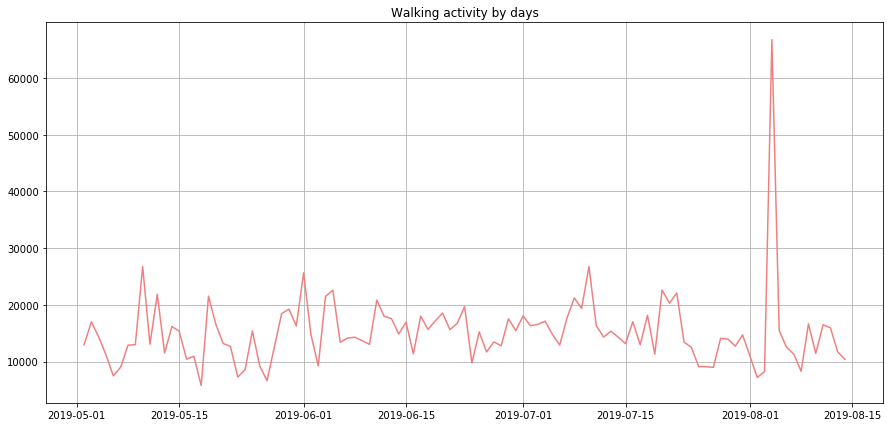

In [12]:
pd.plotting.register_matplotlib_converters()

plt.figure(figsize=(15, 7))
plt.plot(df_daily.index, df_daily['Daily Value'], color='lightcoral')
plt.title('Walking activity by days')
plt.grid(True)

Рассмотрим распределение активности по дням недели. Заметны явные выбросы, но дни необычной активности –– не только они. Необычные дни могут находиться в пределах статистически значимой выборки, в пределах границ усов \
У данного человека бОльшая активность в субботу, но это никак не характеризует остальное население, поэтому не будем опираться на показатель активности по дням недели

Text(0.5, 1.0, 'Boxplots of values grouped by weekdays')

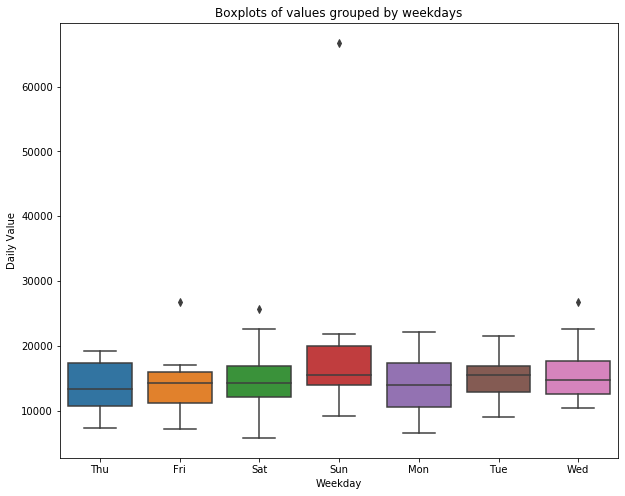

In [13]:
plt.figure(figsize = (10, 8))
sns.boxplot(data = df_daily, x = 'Weekday', y = 'Daily Value')
plt.title('Boxplots of values grouped by weekdays')

#### В функции transform_dataframe выделим признаки: 
'Duration' –– длительность общей активности за день в секундах \
'Daily Value' –– общее количество шагов за день

In [14]:
def transform_dataframe(df):
    
    # Add new columns
    df['Date'] =  pd.to_datetime(df.index.strftime('%Y-%m-%d'))
    df['Duration'] = (df['Time End'] - df['Time Start']).dt.total_seconds()
    
    df_dates = df.groupby('Date', as_index = False)['Value'].sum()
    df_dates.columns = ['Date', 'Daily Value']

    df_dates['Date'] = pd.to_datetime(df_dates['Date'])
    df_dates.set_index('Date', inplace = True)
    
    df_dates['Duration'] = df.groupby('Date', as_index = False)['Duration'].sum()['Duration'].values
    
    return df_dates

In [15]:
df_transf = transform_dataframe(data)
df_transf.head()

,Daily Value,Duration
Date,,
2019-05-02,12977.0,20214.0
2019-05-03,17003.0,19143.0
2019-05-04,14312.0,14158.0
2019-05-05,11124.0,23977.0
2019-05-06,7467.0,12765.0


Выполним кластеризацию по двум признакам, предварительно нормировав данные. Рассмотрим значения параметра k. Выбор k > 5 не целесообразен. \
Стоит отметить, что в данных может не быть явных выбросов (в данном случае день с > 60000 шагов), и наличие 5 кластера ухудшит итоговый результат. Предполагается, что перед кластеризацией можно определить и отбросить очевидные выбросы, а затем заменить число кластеров на 4.

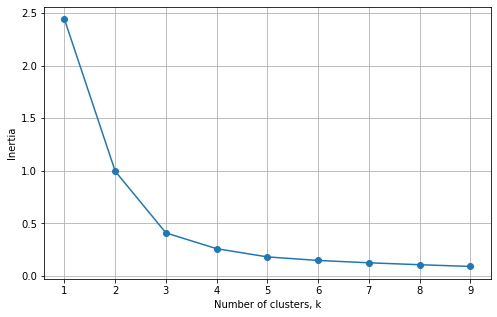

In [16]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_transf.values)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize = (8, 5))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

В функции label_clustered помечаем первые два кластера, содержащие наибольшее число наблюдений, как 'usual'

In [17]:
def label_clustered(df):
    cluster_labels = df['Cluster'].value_counts()
    max_1 = cluster_labels.index[0]
    max_2 = cluster_labels.index[1]
    
    usual_labels = np.array([max_1, max_2])

    df_marked = pd.DataFrame(index   = df.index, 
                             columns = ['Activity'], 
                             dtype   = np.object)
    
    df_marked['Daily Value'] = df['Daily Value'].values
    
    df_marked.loc[df['Cluster'].isin(usual_labels), 'Activity'] = 'usual'
    df_marked.loc[~df['Cluster'].isin(usual_labels), 'Activity'] = 'not usual' 
    
    return df_marked

### Итоговая функция mark_activity

In [18]:
def mark_activity(filename, method = 'cluster', plot_statistics = False, plot_clusters = False):
    
    # Read dataframe
    df = pd.read_csv(filename,
                     sep         = ';|,',
                     engine      = 'python', 
                     index_col   = ['Time Start Local Tz'],
                     parse_dates = ['Time End', 'Time Start', 
                                    'Time End Local Tz',
                                    'Time Start Local Tz'])
    
    df.drop(df[df['Time End Local Tz'] - df.index < dt.timedelta(seconds = 1)].index, 
            inplace = True)
    
    df_dates = transform_dataframe(df)
            
    # Clustering
    k_means = KMeans(n_clusters = 5, random_state = 123)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_dates.iloc[:, 0:2].values)
    k_means.fit(X_scaled)
    y_clust = k_means.predict(X_scaled)
    
    df_dates['Cluster'] = y_clust
    
    # Plot clusters
    if plot_clusters:
        plt.figure(figsize=(14, 6))
        plt.title(f"kMeans clustering result")
        
        colors = ['red', 'green', 'blue', 'olive', 'indigo']
        plt.plot(df_dates.index, 
                 df_dates['Daily Value'], 
                 color = 'salmon', 
                 label = 'Actual values')

        for i in range(5):
            plt.scatter(df_dates[df_dates['Cluster'] == i].index,
                        df_dates.loc[df_dates['Cluster'] == i, 'Daily Value'], 
                        marker     = 'o', 
                        color      = colors[i],
                        label      = str(i))

        plt.legend(loc = 'upper left')
        plt.grid(True)
    
    # Mark days
    df_marked = label_clustered(df_dates)
    
    # Plot daily statistics
    if plot_statistics:
        plt.figure(figsize=(14, 6))
        plt.title(f"Daily activity with marked unusual days")

        plt.plot(df_dates.index, 
                 df_dates['Daily Value'], 
                 color = 'salmon', 
                 label = 'Actual values')
        
        plt.scatter(df_marked[df_marked['Activity'] == 'not usual'].index,
                    df_marked.loc[df_marked['Activity'] == 'not usual', 'Daily Value'].values, 
                    marker     = 'o', 
                    color      = 'teal',
                    label      = 'Unusual')

        plt.legend(loc = 'upper left')
        plt.grid(True)
        
    
    # df_marked.to_csv('marked_activity.csv', encoding = 'utf-8')
    df_marked.drop(columns = ['Daily Value'], inplace = True)
    
    return df_marked

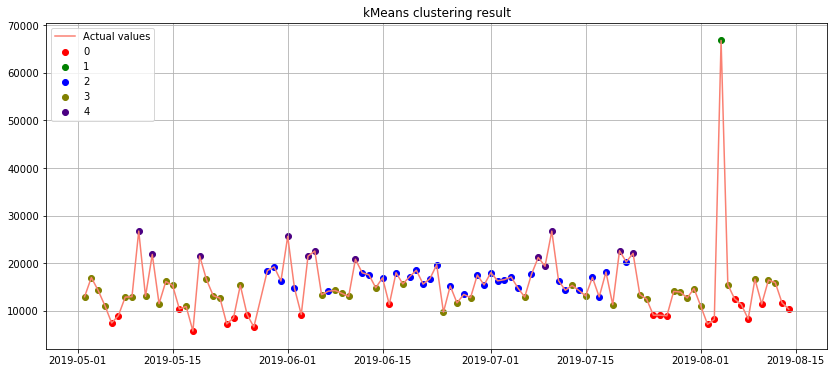

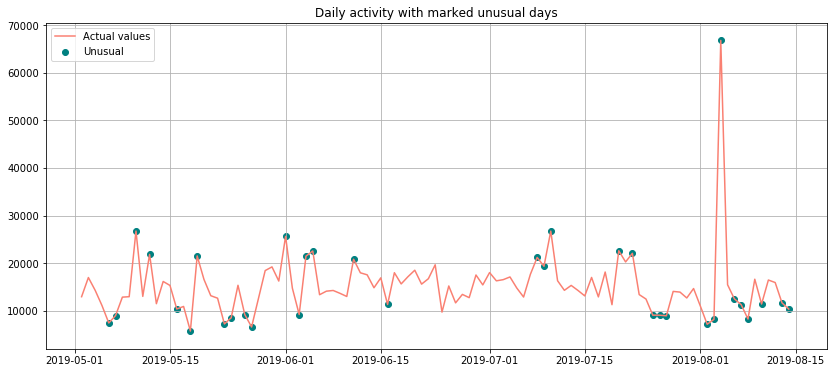

In [19]:
df_result = mark_activity(filename, plot_statistics = True, plot_clusters=True)

In [20]:
df_result.head()

,Activity
Date,
2019-05-02,usual
2019-05-03,usual
2019-05-04,usual
2019-05-05,usual
2019-05-06,not usual
